In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import optimizers
#from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input
from tensorflow.keras.applications import InceptionV3
from keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, Callback
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop, SGD, Adam, Adadelta, Adagrad, Adamax, Nadam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical

import time
import numpy as np
import pandas as pd
import os
import sys
import sklearn
import datetime
import random
import matplotlib.pyplot as plt
import math
import tensorflow as tf
from tensorflow.keras import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Activation, Flatten, BatchNormalization, GlobalAveragePooling2D  
from tensorflow.keras.backend import batch_normalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from packaging import version
%matplotlib inline

Using TensorFlow backend.


In [2]:
def load_training():
    """
    Load the training set (excluding baseline patches)
    """
    images = np.load(os.path.join('Data_again', 'X_train.npy'))
    labels = np.load(os.path.join('Data_again', 'train_labels_multi.npy'))
    return images, labels


def load_testing():
    """
    Load the test set (abnormalities patches and labels, no baseline)
    """
    images = np.load(os.path.join('Data_again', 'X_test.npy'))
    labels = np.load(os.path.join('Data_again', 'y_test_labels_multi.npy'))
    return images, labels


def remap_label(l):
    """
    Remap the labels to:
        0 -> mass benign 
        1 -> mass malignant
        2 -> calcification benign
        3 -> calcification malignant
    """
    if 1 <= l <= 4:
        return l-1
    else:
        print("[WARN] Unrecognized label (%d)" % l)
        return None

In [3]:
# Load training and test images (abnormalities only, no baseline)
train_images, train_labels= load_training()
test_images, test_labels= load_testing()

# Number of images
n_train_img = train_images.shape[0]
n_test_img = test_images.shape[0]
print("Train size: %d \t Test size: %d" % (n_train_img, n_test_img))

# Compute width and height of images
img_w = train_images.shape[1]
img_h = train_images.shape[2]
print("Image size: %dx%d" % (img_w, img_h))

# Convert the labels to categorical format
train_labels = to_categorical(train_labels)
test_labels_raw = test_labels.copy()
test_labels = to_categorical(test_labels)

# Create a new dimension for color in the images arrays
train_images = train_images.reshape((n_train_img, img_w, img_h, 1))
test_images = test_images.reshape((n_test_img, img_w, img_h, 1))

# Convert from 16-bit (0-65535) to to 8-bit (0-255)
train_images = train_images.astype('uint16') / 255
test_images = test_images.astype('uint16') / 255

# Replicate the only color channel (gray) 3 times, for VGGNet compatibility
train_images = np.repeat(train_images, 3, axis=3)
test_images = np.repeat(test_images, 3, axis=3)

# Shuffle the training set (originally sorted by label)
perm = np.random.permutation(n_train_img)
train_images = train_images[perm]
train_labels = train_labels[perm]

# Create a generator for training images
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    validation_split=0.2,
    rotation_range=180,
    shear_range=15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='reflect'
)

# Fit the generator with some images
train_datagen.fit(train_images)

# Split train images into actual training and validation
train_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='training')
validation_generator = train_datagen.flow(train_images, train_labels, batch_size=128, subset='validation')

# Preprocess the test images as well
preprocess_input(test_images);

Train size: 2913 	 Test size: 655
Image size: 256x256


In [4]:
# Build a model using VGG16 convolutional base and new FC final layer

def create_inceptionv3(verbose=False, fc_size=256, dropout=None):
    
    inceptionv3_base = InceptionV3(weights='imagenet',
                       include_top=False,
                       input_shape=(256, 256, 3))
    inceptionv3 = models.Sequential()
    inceptionv3.add(inceptionv3_base)

    inceptionv3.add(layers.Flatten())
    if dropout is not None:
        inceptionv3.add(layers.Dropout(dropout))
    inceptionv3.add(layers.Dense(fc_size, activation='relu'))
    inceptionv3.add(layers.Dense(4, activation='softmax'))

    # Freeze the convolutional base
    inceptionv3_base.trainable = False
    
    if verbose:
        inceptionv3_base.summary()
        inceptionv3.summary()

    return inceptionv3

In [5]:
inceptionv3_fe_drop_temp = create_inceptionv3(verbose=True, dropout=0.5, fc_size=256)

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [5]:
# Instantiate a VGG19 network with custom final layer
inceptionv3_fe_drop_128 = create_inceptionv3(dropout=0.5, fc_size=128)

In [6]:
inceptionv3_fe_drop_128.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 6, 6, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 73728)             0         
_________________________________________________________________
dropout (Dropout)            (None, 73728)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               9437312   
_________________________________________________________________
dense_1 (Dense)              (None, 4)                 516       
Total params: 31,240,612
Trainable params: 9,437,828
Non-trainable params: 21,802,784
_________________________________________________________________


In [7]:
# Early stopping (stop training after the validation loss reaches the minimum)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', patience=30, verbose=1)

# Callback for checkpointing
checkpoint = ModelCheckpoint('inceptionv3_fe_drop_128_4cl_best.h5', 
        monitor='val_loss', mode='min', verbose=1, 
        save_best_only=True, save_freq='epoch'
)

# Compile the model
inceptionv3_fe_drop_128.compile(optimizer=optimizers.RMSprop(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
# Train
history_inceptionv3_fe_drop_128 = inceptionv3_fe_drop_128.fit_generator(
        train_generator,
        epochs=200,
        validation_data=validation_generator,
        callbacks=[checkpoint, earlystopping],
        shuffle=True,
        verbose=1,
        initial_epoch=0
)

Instructions for updating:
Please use Model.fit, which supports generators.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 19 steps, validate for 5 steps
Epoch 1/200
18/19 [===========================>..] - ETA: 1s - loss: 2.9337 - accuracy: 0.3155
Epoch 00001: val_loss improved from inf to 3.68233, saving model to inceptionv3_fe_drop_128_4cl_best.h5
19/19 [==============================] - 36s 2s/step - loss: 2.8523 - accuracy: 0.3153 - val_loss: 3.6823 - val_accuracy: 0.2509
Epoch 2/200
18/19 [===========================>..] - ETA: 1s - loss: 1.3067 - accuracy: 0.3886
Epoch 00002: val_loss did not improve from 3.68233
19/19 [==============================] - 30s 2s/step - loss: 1.3033 - accuracy: 0.3930 - val_loss: 4.8953 - val_accuracy: 0.3093
Epoch 3/200
18/19 [===========================>..] - ETA: 1s - loss: 1.2436 - accuracy: 0.4262
Epoch 00003: val_loss did not improve from 3.68233
19/19 [==============================] - 31s 2s/step - loss: 1.2469 - accuracy: 0.42

Epoch 29/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0507 - accuracy: 0.5315
Epoch 00029: val_loss did not improve from 3.68233
19/19 [==============================] - 30s 2s/step - loss: 1.0524 - accuracy: 0.5315 - val_loss: 12.5717 - val_accuracy: 0.3230
Epoch 30/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0333 - accuracy: 0.5352
Epoch 00030: val_loss did not improve from 3.68233
19/19 [==============================] - 30s 2s/step - loss: 1.0278 - accuracy: 0.5397 - val_loss: 10.6248 - val_accuracy: 0.3110
Epoch 31/200
18/19 [===========================>..] - ETA: 1s - loss: 1.0374 - accuracy: 0.5279
Epoch 00031: val_loss did not improve from 3.68233
19/19 [==============================] - 30s 2s/step - loss: 1.0376 - accuracy: 0.5281 - val_loss: 15.1703 - val_accuracy: 0.3471
Epoch 00031: early stopping


In [9]:
# Save
models.save_model(inceptionv3_fe_drop_128, 'inceptionv3_fe_drop_128_4cl_end.h5')

In [10]:
# History of accuracy and loss
tra_loss_fe = history_inceptionv3_fe_drop_128.history['loss']
tra_acc_fe = history_inceptionv3_fe_drop_128.history['accuracy']
val_loss_fe = history_inceptionv3_fe_drop_128.history['val_loss']
val_acc_fe = history_inceptionv3_fe_drop_128.history['val_accuracy']

In [11]:
# Total number of epochs training
epochs_fe = range(1, len(tra_acc_fe)+1)
end_epoch_fe = len(tra_acc_fe)

# Epoch when reached the validation loss minimum
opt_epoch_fe = val_loss_fe.index(min(val_loss_fe)) + 1

# Loss and accuracy on the validation set
end_val_loss_fe = val_loss_fe[-1]
end_val_acc_fe = val_acc_fe[-1]
opt_val_loss_fe = val_loss_fe[opt_epoch_fe-1]
opt_val_acc_fe = val_acc_fe[opt_epoch_fe-1]

# Loss and accuracy on the test set
opt_inceptionv3_fe_drop_128 = models.load_model('inceptionv3_fe_drop_128_4cl_best.h5')
test_loss_fe, test_acc_fe = inceptionv3_fe_drop_128.evaluate(test_images, test_labels, verbose=False)
opt_test_loss_fe, opt_test_acc_fe = opt_inceptionv3_fe_drop_128.evaluate(test_images, test_labels, verbose=False)

In [12]:
print("inceptionv3 (w/ dropout, smaller FC) Feature Extraction\n")

print("Epoch [end]: %d" % end_epoch_fe)
print("Epoch [opt]: %d" % opt_epoch_fe)
print("Valid accuracy [end]: %.4f" % end_val_acc_fe)
print("Valid accuracy [opt]: %.4f" % opt_val_acc_fe)
print("Test accuracy [end]:  %.4f" % test_acc_fe)
print("Test accuracy [opt]:  %.4f" % opt_test_acc_fe)
print("Valid loss [end]: %.4f" % end_val_loss_fe)
print("Valid loss [opt]: %.4f" % opt_val_loss_fe)
print("Test loss [end]:  %.4f" % test_loss_fe)
print("Test loss [opt]:  %.4f" % opt_test_loss_fe)

inceptionv3 (w/ dropout, smaller FC) Feature Extraction

Epoch [end]: 31
Epoch [opt]: 1
Valid accuracy [end]: 0.3471
Valid accuracy [opt]: 0.2509
Test accuracy [end]:  0.3237
Test accuracy [opt]:  0.2641
Valid loss [end]: 15.1703
Valid loss [opt]: 3.6823
Test loss [end]:  15.1877
Test loss [opt]:  3.2944


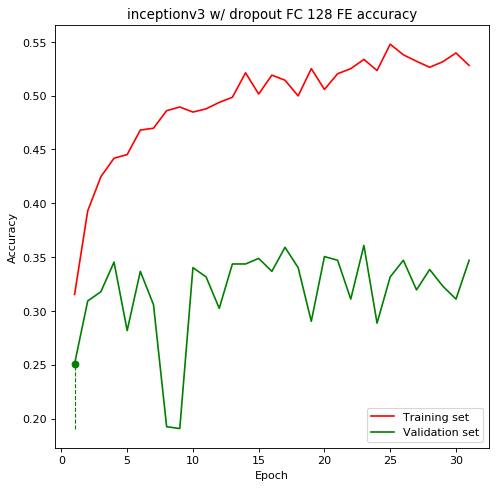

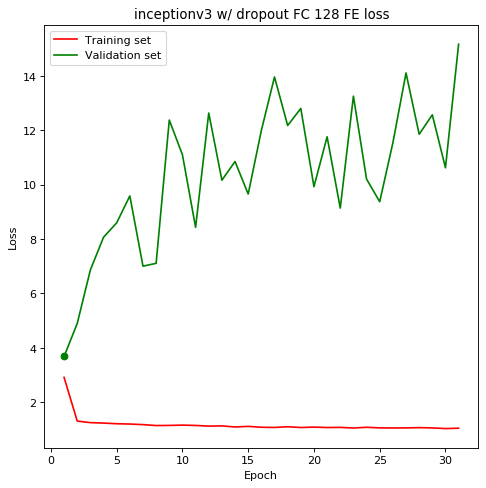

In [13]:
# Model accuracy
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 w/ dropout FC 128 FE accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_acc_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_acc_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_acc_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_acc_fe), opt_val_acc_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_acc_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend(loc='lower right')

# Model loss
plt.figure(figsize=(7, 7), dpi=80, facecolor='w', edgecolor='k')
plt.title('inceptionv3 w/ dropout FC 128 FE loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(epochs_fe, tra_loss_fe, 'r', label='Training set')
plt.plot(epochs_fe, val_loss_fe, 'g', label='Validation set')
plt.plot(opt_epoch_fe, val_loss_fe[opt_epoch_fe-1], 'go')
plt.vlines(opt_epoch_fe, min(val_loss_fe), opt_val_loss_fe, linestyle="dashed", color='g', linewidth=1)
plt.hlines(opt_val_loss_fe, 1, opt_epoch_fe, linestyle="dashed", color='g', linewidth=1)
plt.legend();